In [1]:
#Import required libraries
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import glob
import re
import time
from datetime import datetime

from sklearn.model_selection import train_test_split

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras import mixed_precision
import tensorboard

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt



#Clear session and set random seeds to static
tf.keras.backend.clear_session()
tf.random.set_seed(0)
np.random.seed(0)

In [2]:
%%capture
def import_data(): 

    #week 11
    path = r'C:\Users\Derrick\Box\Anon Data\Undergrad Students\Derrick Bailey\NN Data\week11'
    file = glob.glob(os.path.join(path, "*.csv"))
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

    dfs = []
    for f in file:
        df = pd.read_csv(f)
        dfs.append(df)
    dfs = np.array(dfs, dtype=object)

    institutional_Data = dfs[0]

    gradebook = dfs[1]

    #drop students who do have missing exam scores
    gradebook['M1%'].replace('', 0, inplace=True)
    gradebook['M2%'].replace('', 0, inplace=True)
    gradebook['Final%'].replace('', 0, inplace=True)

    gradebook = gradebook.dropna(axis=0, how='all')

    gradebook = gradebook[gradebook['M1%'] != 0]
    gradebook = gradebook[gradebook['M2%'] != 0]
    gradebook = gradebook[gradebook['Final%'] != 0]

    # with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #     display(gradebook[['M1%','M2%','Final%']])

    clickstream1 = dfs[2] 
    clickstream2 = dfs[3]

    headers = list(clickstream1)
    clickstream2.columns = headers
    clickstream = pd.concat([clickstream1, clickstream2], ignore_index=False)

    institutional_Data_Students = institutional_Data['ID'].unique()
    institutional_Data_Students = pd.DataFrame(institutional_Data_Students)
    institutional_Data_Students = institutional_Data_Students.dropna(axis=0, how='all')
    institutional_Data_Students.columns = ['ID']

    gradebook_Students = gradebook['ID'].unique()
    gradebook_Students = pd.DataFrame(gradebook_Students)
    gradebook_Students = gradebook_Students.dropna(axis=0, how='all')
    gradebook_Students.columns = ['ID']

    clickstream_Students = clickstream['ID'].unique()
    clickstream_Students = pd.DataFrame(clickstream_Students)
    clickstream_Students = clickstream_Students.dropna(axis=0, how='all')
    clickstream_Students.columns = ['ID']

    #delete students in clickstream and institutional if not present in gradebook
    institutional_Data_Students = institutional_Data_Students[institutional_Data_Students.ID.isin(gradebook_Students.ID)].dropna()
    clickstream_Students = clickstream_Students[clickstream_Students.ID.isin(gradebook_Students.ID)].dropna()

    #check that students in institutional_Data match students in clickstream
    class StudentError(Exception):
        pass
    try:
        student_Check = clickstream_Students.iloc[:,0].str.strip().str.lower().unique().all() == institutional_Data_Students.iloc[:,0].str.strip().str.lower().unique().all() == gradebook_Students.iloc[:,0].str.strip().str.lower().unique().all()
        if student_Check != True:
            raise StudentError
    except StudentError:
        print("Students in Dataframes do not match!")
        assert False
    except(SyntaxError):
        print("Syntax Issue!")
        assert False

    #Collect demographics
#     assert demographic
    demo_gate = input("Use demographics? Y/N: ")
    if demo_gate == "Y":
        demo = input("Select Demographic. Type EXACTLY as contained in the .csv file: ")
#         demo = "W - White"
        demo_type = input("Column name of demographic. Type EXACTLY as contained in the .csv file: ")
        institutional_Data = institutional_Data[institutional_Data[demo_type].str.contains(demo)==True]

#     display(institutional_Data)

    #Parse through Institutional Data to generate featureset
    institutional_Data_cols = list(institutional_Data.columns)
    # drop any and all columns that are all ZERO (necessary: columns of zeroes will influence weighting and prediction)
    institutional_Data = institutional_Data.loc[:, (institutional_Data !=0).any(axis=0)]
    # drop any and all columns that are all NaN (necessary step - matrix operation on NaN will result in all operations NaN)
    institutional_Data = institutional_Data.dropna(axis=1, how='all')
    # fill NaN with zeroes
    institutional_Data = institutional_Data.fillna(0)
    institutional_Data = institutional_Data[institutional_Data.ID.isin(institutional_Data_Students.ID)]
    institutional_Data_Features = ["ID","OVERALL OSU GPA","OSU GPA","OSU CREDITS ATTEMPT","OSU CREDITS EARNED"]
    institutional_Data = institutional_Data.loc[:, institutional_Data_Features].copy()

    # display(gradebook_Students)

    #delete students in clickstream and gradebook if not present in institutional_data (demographic filter)
    institutional_Data_Students = institutional_Data_Students[institutional_Data_Students.ID.isin(institutional_Data.ID)].dropna()
    clickstream_Students = clickstream_Students[clickstream_Students.ID.isin(institutional_Data.ID)].dropna()
    gradebook_Students = gradebook_Students[gradebook_Students.ID.isin(institutional_Data.ID)].dropna()

    # display(gradebook_Students)

    institutional_Data = institutional_Data[institutional_Data.ID.isin(institutional_Data_Students.ID)].dropna()
    clickstream = clickstream[clickstream.ID.isin(clickstream_Students.ID)].dropna()
    gradebook = gradebook[gradebook.ID.isin(gradebook_Students.ID)]

    # display(institutional_Data)
    # display(clickstream)
    # display(gradebook[gradebook.ID.isin(gradebook_Students.ID)])

    #recatch students
    institutional_Data_Students = institutional_Data['ID'].unique()
    institutional_Data_Students = pd.DataFrame(institutional_Data_Students)
    institutional_Data_Students = institutional_Data_Students.dropna(axis=0, how='all')
    institutional_Data_Students.columns = ['ID']

    gradebook_Students = gradebook['ID'].unique()
    gradebook_Students = pd.DataFrame(gradebook_Students)
    gradebook_Students = gradebook_Students.dropna(axis=0, how='all')
    gradebook_Students.columns = ['ID']

    clickstream_Students = clickstream['ID'].unique()
    clickstream_Students = pd.DataFrame(clickstream_Students)
    clickstream_Students = clickstream_Students.dropna(axis=0, how='all')
    clickstream_Students.columns = ['ID']

    #Parse through Gradebook Data to generate featureset
    gradebook_cols = list(gradebook.columns)
    #feature list for gradebook
    gradebook_features = ['ID', 'raw','online','HW%','RW%','Rec %','Lab %','M1%','M2%','Final%','Overall Grade %']
    gradebook = gradebook[gradebook_features]
    del gradebook['M1%']
    del gradebook['M2%']
    del gradebook['Final%']
    gradebook = gradebook[gradebook.ID.isin(institutional_Data.ID)].dropna()
    final_Grade = gradebook['Overall Grade %']
    final_Grade = pd.DataFrame([final_Grade]).T
    final_Grade = final_Grade.values
    final_Grade = pd.DataFrame(final_Grade)
    # remove final grade from gradebook
    del gradebook['Overall Grade %']
    # drop any and all columns that are all ZERO (necessary: columns of zeroes will influence weighting and prediction)
    gradebook = gradebook.loc[:, (gradebook !=0).any(axis=0)]
    # drop any and all columns that are all NaN (necessary step - matrix operation on NaN will result in all operations NaN)
    gradebook = gradebook.dropna(axis=1, how='all')
    # fill NaN with zeroes
    gradebook = gradebook.fillna(0)
    # recatch cols var
    cols = list(gradebook.columns)
    gradebook = gradebook[gradebook.ID.isin(gradebook_Students.ID)]

    #Parse through Clickstream Data to generate featureset
    clickstream_cols = list(clickstream.columns)
    clickstream.set_index=clickstream['ID']
    # drop any and all columns that are all ZERO (necessary: columns of zeroes will influence weighting and prediction)
    clickstream = clickstream.loc[:, (clickstream !=0).any(axis=0)]
    # drop any and all columns that are all NaN (necessary step - matrix operation on NaN will result in all operations NaN)
    clickstream = clickstream.dropna(axis=1, how='all')
    # fill NaN with zeroes
    clickstream = clickstream.fillna(0)
    clickstream = clickstream[clickstream.ID.isin(clickstream_Students.ID)]

    # now to parse through for specific features
    # create list out of student column
    student_list = clickstream[['ID']]
    student_list_unique = pd.DataFrame(student_list['ID'].unique())
    student_list_unique.columns = ['ID']
    clickstream_features = ['m1_sols', 'm2_sols','f_sols', '#Practice', '#Fundamental', 'Calendar', 'KALTURA', 'youtube']
    clickstream_cut = clickstream[clickstream['Page title'].str.contains("|".join(clickstream_features))]

    studentdf = []
    studentdf = [x for _, x in clickstream_cut.groupby(by='ID')]

    clickstream_Data = []
    clickstream_Data = pd.DataFrame(columns = clickstream_features)
    clickstream_Data = student_list_unique.append(clickstream_Data)

    count = []

    #automated feature-by-feature approach
    for feature in clickstream_features:
        for pos in studentdf:
            for ID in pos['ID'].unique():
                ID = pos['ID'].unique()
                count.append(pos['Page title'].str.contains(feature).sum())
        clickstream_Data[feature] = count
        count.clear()

    frames = pd.merge(institutional_Data, gradebook, on='ID')
    frames = pd.merge(frames, clickstream_Data, on='ID')

    #     final_Grade = final_Grade[final_Grade.ID.isin(institutional_Data_Students.ID)].dropna()

    input_Features = frames
    feature_num = len(input_Features.columns)

    #week 4
    pre_Lecture_Max = {
        "AQ.L1.1":8,
        "AQ.L2.1":8,
        "GA.L1.1":6,
        "GR.L1.1":18,
        "K1.L1.1":6,
        "K1.L2.1":6,
        "K2.L1.1":6,
        "K2.L2.1":6,
        "VO.L1.1":11
    }
    pre_Lecture_Max_Values = pre_Lecture_Max.values()
    pre_Lecture_Max_Values_List = list(pre_Lecture_Max_Values)
    pre_Lecture_Keys = list(pre_Lecture_Max.keys())

    post_Lecture_Max = {
        "AQ.L1.3":5,
        "AQ.L2.3":4,
        "GA.L1.3":8,
        "GR.L1.3":13,
        "K1.L1.3":8,
        "K1.L2.3":9,
        "K2.L1.3":4,
        "K2.L2.3":15,
        "VO.L1.3":16
    }
    post_Lecture_Max_Values = post_Lecture_Max.values()
    post_Lecture_Max_Values_List = list(post_Lecture_Max_Values)
    post_Lecture_Keys = list(post_Lecture_Max.keys())

    path = r'C:\Users\Derrick\Box\Anon Data\Undergrad Students\Derrick Bailey\NN Data\week4'
    file = glob.glob(os.path.join(path, "*.csv"))
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

    pre_Lecture = []
    post_Lecture = []

    for f in file:
        with open(f) as src_file:
            encoding = src_file.encoding
        if 'pre' in f.lower():
    #         print("Test1")
            df = pd.read_csv(f, encoding=encoding, usecols=['sis_id','attempt','score'])
            pre_Lecture.append(df)
        if 'post' in f.lower():
    #         print("Test2")
            df = pd.read_csv(f, encoding=encoding, usecols=['sis_id','attempt','score'])
            post_Lecture.append(df)

    #grab students for pre and post lecture

    prelec_students = []
    postlec_students = []

    for i in range(len(pre_Lecture)):
        holder = pd.DataFrame(pre_Lecture[i])
        holder['sis_id'].unique()
        for string in holder['sis_id']:
            if string not in prelec_students:
                prelec_students.append(string)
    prelec_students = pd.DataFrame(prelec_students)
    prelec_students.rename(columns={0:'ID'}, inplace=True)

    for i in range(len(post_Lecture)):
        holder = pd.DataFrame(post_Lecture[i])
        holder['sis_id'].unique()
        for string in holder['sis_id']:
            if string not in postlec_students:
                postlec_students.append(string)
    postlec_students = pd.DataFrame(postlec_students)
    postlec_students.rename(columns={0:'ID'}, inplace=True)

    #compare students from assignments to gradebook students, delete those not present in gradebook

    prelec_students = prelec_students[prelec_students.ID.isin(institutional_Data.ID)].dropna()
    postlec_students = postlec_students[postlec_students.ID.isin(institutional_Data.ID)].dropna()

    pre_Lecture = np.array(pre_Lecture, dtype=object)
    post_Lecture = np.array(post_Lecture, dtype=object)

    #now we have an array of arrays containing unique students for every pre/post lecture, and two array of arrays containing the pre/post lectures. 
    #Need to get maximum score for every student and get attempt num

    popout_prelec = pre_Lecture[0]
    popout_prelec = pd.DataFrame(popout_prelec)
    popout_postlec = post_Lecture[0]
    popout_postlec = pd.DataFrame(popout_postlec)

    #go through students, find max score, keep row, drop other rows containing studentxxx
    pre_Lecture_modified = []
    post_Lecture_modified = []

    i=0
    for array in post_Lecture:
    #initial dataframe
        popout_postlec = array
        df_max = popout_postlec.groupby('sis_id').idxmax()
        df_max['type'] = 'max'
    #index sort
        df2 = df_max.set_index('type',append=True).stack().rename('index')
    #concatenation
        df3 = pd.concat([ df2.reset_index().drop('sis_id',axis=1).set_index('index'), 
                          popout_postlec.loc[df2.values] ], axis=1)
        df3.set_index(['sis_id','level_2','type']).sort_index()
    #groupby aggregate and reset index   
        df3 = df3.groupby(['sis_id', 'attempt']).agg({'score': 'max'}).reset_index()
        df3 = df3.drop_duplicates(subset=['sis_id'], keep='first').reset_index(drop=True)
        df3['Percent'] = df3['score'] / post_Lecture_Max_Values_List[i]
        i = i + 1
        post_Lecture_modified.append(df3)

    # print("PRE LEC \n \n \n")    

    j=0
    for array in pre_Lecture:
    #initial dataframe
        popout_prelec = array
    #groupby ID
        df_max = popout_prelec.groupby('sis_id').idxmax()
        df_max['type'] = 'max'
    #index sort
        df2 = df_max.set_index('type',append=True).stack().rename('index')
    #concatenation
        df3 = pd.concat([ df2.reset_index().drop('sis_id',axis=1).set_index('index'), 
                          popout_prelec.loc[df2.values] ], axis=1)
        df3.set_index(['sis_id','level_2','type']).sort_index()
    #groupby aggregate and reset index    
        df3 = df3.groupby(['sis_id', 'attempt']).agg({'score': 'max'}).reset_index()
        df3 = df3.drop_duplicates(subset=['sis_id'], keep='first').reset_index(drop=True)
        df3['Percent'] = df3['score'] / pre_Lecture_Max_Values_List[j]
        j = j + 1
        pre_Lecture_modified.append(df3)

    # print("-------------------------------------", "\n", "PRELECTURE", "\n", "-------------------------------------")
    number = 0
    pre_Lecture_finished = []
    for frame in pre_Lecture_modified:
    #if student ID not in assignment but in overall prelecture submissions, add student ID
        for student in list(prelec_students['ID'].sort_values()):
    #         print(student)
            if student not in list(frame['sis_id'].unique()):
    #             print("Missing: ", student)
                frame.loc[len(frame.index) + 1] = student
        frame['attempt'] = pd.to_numeric(frame['attempt'], errors='coerce').fillna(0)
        frame['score'] = pd.to_numeric(frame['score'], errors='coerce').fillna(0)
        frame['Percent'] = pd.to_numeric(frame['Percent'], errors='coerce').fillna(0)
        frame.rename(columns={"attempt": "prelec_Attempt", "score": "prelec_Score", "Percent": "prelec_Percent"}, inplace=True)
    #if student ID in assignment but did not finish course, delete student ID
        for student in list(frame['sis_id'].unique()):
    #         print("Student from frame: ", student)
            if student not in list(prelec_students['ID'].sort_values()):
    #             print("Extraneous: ", student)
                frame = frame[frame["sis_id"].str.contains(student)==False]
        number += 1
        pre_Lecture_finished.append(frame.sort_values('sis_id'))

    del number    
    del frame

    # display(pre_Lecture_modified)
    # print("-------------------------------------", "\n", "POSTLECTURE", "\n", "-------------------------------------")

    number = 0
    post_Lecture_finished = []
    for frame in post_Lecture_modified:
    #if student ID not in assignment but in overall postlecture submissions, add student ID
        for student in list(postlec_students['ID'].sort_values()):
    #         print(student)
            if student not in list(frame['sis_id'].unique()):
    #             print("Missing: ", student)
                frame.loc[len(frame.index) + 1] = student
        frame['attempt'] = pd.to_numeric(frame['attempt'], errors='coerce').fillna(0)
        frame['score'] = pd.to_numeric(frame['score'], errors='coerce').fillna(0)
        frame['Percent'] = pd.to_numeric(frame['Percent'], errors='coerce').fillna(0)
        frame.rename(columns={"attempt": "postlec_Attempt", "score": "postlec_Score", "Percent": "postlec_Percent"}, inplace=True)
    #if student ID in assignment but did not finish course, delete student ID
        for student in list(frame['sis_id'].unique()):
    #         print("Student from frame: ", student)
            if student not in list(postlec_students['ID'].sort_values()):
    #             print("Extraneous: ", student)
                frame = frame[frame["sis_id"].str.contains(student)==False]
        number += 1
        post_Lecture_finished.append(frame.sort_values('sis_id'))
    # for frame in post_Lecture_modified:
    #     display(frame)
    #     frame.to_csv(r'C:\Users\Derrick\Box\Anon Data\Undergrad Students\Derrick Bailey\NN Data\week4\frame_%s.csv' %number)

    del frame
    del number

    assignment = 0
    for item in pre_Lecture_finished:
        item.drop(['prelec_Score'], axis=1, inplace=True)
        item.rename(columns={'sis_id':'ID'}, inplace=True)
        item.rename(columns={'prelec_Attempt': pre_Lecture_Keys[assignment] + ' Attempts', 'prelec_Percent': pre_Lecture_Keys[assignment] + ' Percent'}, inplace=True)
        assignment += 1

    del assignment

    assignment = 0
    for item in post_Lecture_finished:
        item.drop(['postlec_Score'], axis=1, inplace=True)
        item.rename(columns={'sis_id':'ID'}, inplace=True)
        item.rename(columns={'postlec_Attempt': post_Lecture_Keys[assignment] + ' Attempts', 'postlec_Percent': post_Lecture_Keys[assignment] + ' Percent'}, inplace=True)
        assignment += 1

    del assignment

    pre_and_post = pre_Lecture_finished + post_Lecture_finished
    for item in pre_and_post:
        input_Features = pd.merge(input_Features, item, on='ID')

    input_Features.drop(columns=['m1_sols','m2_sols','f_sols', 'Lab %'], inplace=True)

#     with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#         display(input_Features)

    return input_Features, final_Grade, studentdf, student_list_unique

In [3]:
%%capture
def debug(debug=False):
    while debug == True:
        debug_input = int(input("Invoke the rite of passage! \n \
        1: Final Grades Dataframe \n \
        2: Student Dataframe \n \
        3: Input Features Dataframe \n \
        4: Exit \n"))
        if debug_input == 1:
            print("Final Grades Dataframe")
            display(final_Grade)
            break
        elif debug_input == 2:
            print("Student Dataframe")
            display(studentdf)
            break
        elif debug_input == 3:
            print("Input Features Dataframe")
            display(input_Features)
            break
        elif debug_input == 4:
            debug_input = False
            break
        else:
            print("Invalid input")

In [4]:
%%capture
def process_data(input_Features, final_Grade):
    # Split data for train/test
    x_train, x_test, y_train, y_test = train_test_split(input_Features, final_Grade, 
                                                        test_size=0.33, random_state=0)
    # test
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # delete student column before normalization but saving student column
    x_train_student = x_train[:,0]
    x_test_student = x_test[:,0]
    x_train = np.delete(x_train, 0, 1)
    x_test = np.delete(x_test, 0, 1)
    
    # Normalization
    sc = MinMaxScaler(feature_range = (0,1))
    x_train_norm = sc.fit_transform(x_train)
    x_test_norm = sc.fit_transform(x_test)
    y_train_norm = sc.fit_transform(y_train)
    y_test_norm = sc.fit_transform(y_test)

    x_train_norm = np.reshape(x_train_norm, (x_train_norm.shape[0], x_train_norm.shape[1], 1))
    x_test_norm = np.reshape(x_test_norm, (x_test_norm.shape[0], x_test_norm.shape[1], 1))
    
    return x_train_norm, x_test_norm, y_train_norm, y_test_norm, x_train_student, x_test_student, sc

In [5]:
%%capture
def student_cross_ref(student_list_unique, final_Grade, predicted_Grade):
    # We must cross-reference the split data with the final grade master list
    # and pull only the matching student numbers from the final grade master list.

    # Start by zipping together student dataframe and final grade dataframe.
    final_Grade = np.hstack((student_list_unique, final_Grade))
    final_Grade = pd.DataFrame(final_Grade)
    # To make our lives easy, let's name the columns for our predicted and final grade dataframes.
    final_Grade.columns = ['FStudent','FGrade']
    predicted_Grade.columns = ['PStudent','PGrade']
    # Now, we compare the student columns for these dataframes.
    merged_Grades = final_Grade.merge(predicted_Grade, left_on = 'FStudent', right_on = 'PStudent', how = 'left')
    # with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #     display(merged_Grades)
    merged_Grades = merged_Grades[merged_Grades['PStudent'].notna()]
    return merged_Grades

In [6]:
def hyperparameter_optimization(hyp_opt):   
    if hyp_opt == "Y":
        #this is way too big.
#         param_list = [[*range(100,1100,100)], 
#                       [*map(lambda x: 2 ** x, range(8,-1,-1))], 
#                       [*map(lambda x: 1*10**(-x), range(5))], 
# #                       [*map(lambda x: 1*10**(-1-x), range(5))], 
#                       list(np.linspace(0.05,0.3,6).round(decimals=2)),
#                       list(np.linspace(0.05,0.3,6).round(decimals=2)), 
#                       list(np.linspace(0.05,0.3,6).round(decimals=2)), 
#                       list(np.linspace(0.05,0.3,6).round(decimals=2)), 
#                       list(np.linspace(0.05,0.3,6).round(decimals=2)), 
#                       list(np.linspace(0.05,0.3,6).round(decimals=2)),
#                       [*map(lambda x: 2 ** x, range(10))],
#                       [*map(lambda x: 2 ** x, range(10))], 
#                       [*map(lambda x: 2 ** x, range(10))]]
        param_list = [[500], 
                      [1,8], 
                      [1e-4],
                      [0.15],
                      [0.15], 
                      [0.15], 
                      [0.2], 
                      [0.2], 
                      [0.2],
                      [*map(lambda x: 5 ** x, range(5,7))],
                      [*map(lambda x: 5 ** x, range(4,6))], 
                      [*map(lambda x: 5 ** x, range(3,6))]]
        hype_var_list_index = ['num_epochs', 'batch_size', 'lr', 'recurrent_dropout1', 'recurrent_dropout2', 'recurrent_dropout3', 'dropout1', 'dropout2', 'dropout3', 'gru_units1', 'gru_units2', 'gru_units3']

        num_epochs, batch_size, lr, recurrent_dropout1, recurrent_dropout2, recurrent_dropout3, dropout1, dropout2, dropout3, gru_units1, gru_units2, gru_units3 = [param_list[i] for i in range(len(param_list))]
        hype_var_list = pd.DataFrame(index=hype_var_list_index,
                                      data=([num_epochs], 
                                      [batch_size], 
                                      [lr], 
                                      [recurrent_dropout1], 
                                      [recurrent_dropout2], 
                                      [recurrent_dropout3], 
                                      [dropout1], 
                                      [dropout2], 
                                      [dropout3], 
                                      [gru_units1], 
                                      [gru_units2], 
                                      [gru_units3]))
        optimize_gate = True
#         hype_var_list.DataFrame()
#         print(hype_var_list)
#         print(hype_var_list)
        return hype_var_list, optimize_gate
    if hyp_opt == "N":
        param_list = [500, 1, 1e-3, 0.15, 0.15, 0.15, 0.2, 0.2, 0.2, 625, 125, 25]
        num_epochs, batch_size, lr, recurrent_dropout1, recurrent_dropout2, recurrent_dropout3, dropout1, dropout2, dropout3, gru_units1, gru_units2, gru_units3 = [param_list[i] for i in range(len(param_list))]
        hype_var_list = [num_epochs, 
                         batch_size, 
                         lr, 
                         recurrent_dropout1, 
                         recurrent_dropout2, 
                         recurrent_dropout3, 
                         dropout1, 
                         dropout2, 
                         dropout3, 
                         gru_units1, 
                         gru_units2, 
                         gru_units3]
        optimize_gate = False
        return hype_var_list, optimize_gate
    elif hyp_opt != "Y" and hyp_opt != "N":
        print("Try Again!")
        hyp_opt = hyperparameter_optimization(input("Optimize? "))

In [7]:
def EvaluateModel(hype_var_list, optimize_gate, x_train_norm, y_train_norm, x_test_norm, x_test_student, sc, student_list_unique, final_Grade):
    if optimize_gate == True:
        index = hype_var_list.index
        for i in hype_var_list:
            num_epochs, batch_size, lr, recurrent_dropout1, recurrent_dropout2, recurrent_dropout3, dropout1, dropout2, dropout3, gru_units1, gru_units2, gru_units3 = hype_var_list[i]
        for a in range(len(num_epochs)):
#             print("num_epochs: ", a, "\n")
            for b in range(len(batch_size)):
#                 print("batch_size: ", b, "\n")
                for c in range(len(lr)):
#                     print("lr: ", c, "\n")
#                         print("decay: ", d, "\n")
                        for d in range(len(recurrent_dropout1)):
#                             print("recurrent_dropout1: ", e, "\n")
                            for e in range(len(recurrent_dropout2)):
#                                 print("recurrent_dropout2: ", f, "\n")
                                for f in range(len(recurrent_dropout3)):
#                                     print("recurrent_dropout3: ", g, "\n")
                                    for g in range(len(dropout1)):
#                                         print("dropout1: ", h, "\n")
                                        for h in range(len(dropout2)):
#                                             print("dropout2: ", i, "\n")
                                            for i in range(len(dropout3)):
#                                                 print("dropout3: ", j, "\n")
                                                for j in range(len(gru_units1)):
#                                                     print("gru_units1: ", k, "\n")
                                                    for k in range(len(gru_units2)):
#                                                         print("gru_units2: ", l, "\n")
                                                        for l in range(len(gru_units3)):
#                                                             print("gru_units3: ", m, "\n")
                                                            hype_list = [num_epochs[a],batch_size[b],lr[c],recurrent_dropout1[d],recurrent_dropout2[e],recurrent_dropout3[f],dropout1[g],dropout2[h],dropout3[i],gru_units1[j],gru_units2[k],gru_units3[l]]
#                                                             print(hype_list)
                                                            BuildModel(x_train_norm, y_train_norm, x_test_norm, x_test_student, sc, hype_list, student_list_unique, final_Grade)
        #BuildModel()
#         pass
    if optimize_gate == False:
        #train on defaults
#         print(hype_var_list)
#         for i in hype_var_list:
        num_epochs, batch_size, lr, recurrent_dropout1, recurrent_dropout2, recurrent_dropout3, dropout1, dropout2, dropout3, gru_units1, gru_units2, gru_units3 = hype_var_list
#         print(num_epochs, batch_size, lr, recurrent_dropout1, recurrent_dropout2, recurrent_dropout3, dropout1, dropout2, dropout3, gru_units1, gru_units2, gru_units3)
        hype_list = [num_epochs, batch_size, lr, recurrent_dropout1, recurrent_dropout2, recurrent_dropout3, dropout1, dropout2, dropout3, gru_units1, gru_units2, gru_units3]
        BuildModel(x_train_norm, y_train_norm, x_test_norm, x_test_student, sc, hype_list, student_list_unique, final_Grade)
#         pass

In [8]:
def visualize_chaos(merged_Grades, loss_df, mae, mse, fit, timestamp):
    # Visualize the chaos
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.scatter(merged_Grades.iloc[:,3],merged_Grades.iloc[:,1], c=merged_Grades.iloc[:,3], cmap = 'jet_r', edgecolors='black')
    ax1.set_xlabel('Predicted Grade')
    ax1.set_ylabel('Actual Grade')
    min_predicted = merged_Grades['PGrade'].min()
    ax1.set_xlim(0,100)
    ax1.set_ylim(0,100)

    ax2.plot(loss_df[['loss', 'val_loss']])
#     print(loss_df)
    ax2.set_xlabel("Number of Epochs")
    ax2.set_ylabel("Loss")
    ax2.plot(fit.history['loss'], label = 'Loss on Training Set')
    ax2.plot(fit.history['val_loss'], label = 'Loss on Validation Set')
    ax2.legend()
    textstr = '\n'.join((
        r'$MAE = %1.3f$' %mae,
        r'$MSE = %1.3f$' %mse))

    ax1.text(0.05, 0.95, textstr, transform = ax1.transAxes, fontsize = 14, va = 'top')

    lims1 = [
        np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
        np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
    ]

    lims2 = [
         np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
         np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax1.plot(lims1, lims1, 'k-', alpha=0.5, zorder=0)

    ax1.grid()
    fig.tight_layout()
    fig.subplots_adjust(right=2, wspace=0.2)
    
#     datetime = time.strftime("%Y-%m-%d %H-%M-%S")
#     fig.savefig("Figure "+ datetime.str() + ".png")
    
    plt.show()
    figname = timestamp
    fig.savefig("Graphs/GRU/Week 4/{}.svg".format(figname), transparent=False, facecolor = 'w', bbox_inches='tight')
    fig.savefig("Graphs/GRU/Week 4/{}.png".format(figname), transparent=False, facecolor = 'w', bbox_inches='tight')

In [9]:
def correlation_heatmap(train):
    train = pd.DataFrame(train, columns=cols)
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, vmin=-1.0, center=0, fmt='.2f',
                square=True, linewidths=1, annot=True, cmap = 'vlag', cbar_kws={"shrink": .70})
    savegraph = input('Do you want to save this graph? Y/N: ')
    if savegraph == "Y":
        figname = input('Graph name: ')
        fig.savefig("Graphs/{}.svg".format(figname), transparent=False, facecolor = 'w', dpi=150)
        fig.savefig("Graphs/{}.png".format(figname), transparent=False, facecolor = 'w', dpi=150)
    plt.show();
# input_Features, final_Grade, studentdf, student_list_unique = import_data()
# cols = list(input_Features.keys())
# cols.pop(0)
# x_train_norm, x_test_norm, y_train_norm, y_test_norm, x_train_student, x_test_student, sc = process_data(input_Features, final_Grade)
# x_train_norm = pd.DataFrame(x_train_norm, columns=cols)
# y_train_norm = pd.DataFrame(y_train_norm, columns=['final_Grade'])
# combined = pd.concat([x_train_norm, y_train_norm], axis=1)
# cols.append('final_Grade')
# correlation_heatmap(combined)

In [10]:
# @tf.function(jit_compile=True)
def BuildModel(x_train_norm, y_train_norm, x_test_norm, x_test_student, sc, hype_list, student_list_unique, final_Grade):
    num_epochs, batch_size, lr, recurrent_dropout1, recurrent_dropout2, recurrent_dropout3, dropout1, dropout2, dropout3, gru_units1, gru_units2, gru_units3 = hype_list
#     print(num_epochs, batch_size, lr, recurrent_dropout1, recurrent_dropout2, recurrent_dropout3, dropout1, dropout2, dropout3, gru_units1, gru_units2, gru_units3)
#     print(x_train_norm.shape)

    #GRU model
#     type(x_train_norm)
#     tf.keras.backend.set_floatx('float32')
#     tf.keras.mixed_precision.set_global_policy('mixed_float16')
    
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.keras.mixed_precision.experimental.set_policy(policy)
    display(hype_list)
    with tf.device('/gpu:0'):
        # NN Parameters
        # Initialization
        RNN = Sequential()
        start = time.perf_counter()
        # 1st GRU layer & Dropout regularisation
        RNN.add(GRU(units=gru_units1, return_sequences=True, recurrent_dropout=recurrent_dropout1, input_shape=(x_train_norm.shape[1], 1)))
        RNN.add(Dropout(dropout1))
#         RNN.add(BatchNormalization())
        # 2nd GRU Layer & Dropout regularisation
        RNN.add(GRU(units=gru_units2, return_sequences=True, recurrent_dropout=recurrent_dropout2))
        RNN.add(Dropout(dropout2))
#         RNN.add(BatchNormalization())
        # 3rd GRU Layer & Dropout regularisation
        RNN.add(GRU(units=gru_units3, recurrent_dropout=recurrent_dropout3))
        RNN.add(Dropout(dropout3))
#         RNN.add(BatchNormalization())
        # 4th GRU Layer
#         RNN.add(GRU(units=50, recurrent_dropout=0.1))
    #   RNN.add(BatchNormalization())
        # Output Layer
        RNN.add(Dense(units = 1))
        # Compiling RNN
        loss = tf.keras.losses.MeanSquaredError()
        decayed_lr = tf.keras.optimizers.schedules.ExponentialDecay(lr, 1000, 0.96, staircase=False)
        opt = tf.keras.optimizers.Adam(learning_rate=decayed_lr)
        RNN.compile(optimizer=opt, loss=loss)

        #Early Stop Callback
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
        min_delta = 1e-4, 
        patience=50, 
        restore_best_weights = True)
        #Checkpoint Callback
        checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=r'C:\Users\OSU_bailderr\Box\Anon Data\Undergrad Students\Derrick Bailey\NN Repository\Checkpoints',
        save_weights_only=True,
        monitor='val_loss',
        mode='max',
        save_best_only=True)
        #Tensorboard Callback
        logdir='logs\\fit\\' + datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

        # Fitting RNN to training set
        fit = RNN.fit(x_train_norm, y_train_norm, epochs = num_epochs, batch_size = batch_size, validation_split=0.33, callbacks=[early_stop, tensorboard], shuffle=True, use_multiprocessing=True)
        loss_df = pd.DataFrame(fit.history)
        print(RNN.summary())
    elapsed = time.perf_counter() - start
    print('Elapsed %.3f seconds.' % elapsed)
    # Evaluate mode
    # history = RNN.evaluate(x_test_norm, y_test_norm, batch_size = 1)

    # Predicted Grade
    predicted_Grade = RNN.predict(x_test_norm, verbose=1, use_multiprocessing=True)
    # predicted_Grade_Dataset = np.zeros(shape=(len(predicted_Grade), 10))
    # predicted_Grade_Dataset[:,0] = predicted_Grade[:,0]
    predicted_Grade = sc.inverse_transform(predicted_Grade)[:,0]
    predicted_Grade = np.vstack((x_test_student, predicted_Grade))
    predicted_Grade = predicted_Grade.T
    predicted_Grade = pd.DataFrame(predicted_Grade)
    
    
#     return predicted_Grade, loss_df

    merged_Grades = student_cross_ref(student_list_unique, final_Grade, predicted_Grade)
    #compute MAE & MSE
    mae = tf.keras.losses.MeanAbsoluteError()
    mse = tf.keras.losses.MeanSquaredError()
    #write MAE from scratch, compare to tf???
    mae = mae(merged_Grades.iloc[:,3],merged_Grades.iloc[:,1]).numpy()
    mse = mse(merged_Grades.iloc[:,3],merged_Grades.iloc[:,1]).numpy()
    #catch params
    timestamp = time.strftime("%Y-%m-%d %H-%M-%S")

    path = r'C:\Users\Derrick\Box\Anon Data\Undergrad Students\Derrick Bailey\NN Repository\Graphs\GRU\Week 4\\'
    path = path + timestamp + '.csv'

    hype_list = pd.DataFrame(hype_list)
    hype_list.to_csv(path, index=False)
    visualize_chaos(merged_Grades, loss_df, mae, mse, fit, timestamp)

Use demographics? Y/N:  N
Optimize Hyperparameters? Y/N:  N


[500, 1, 0.001, 0.15, 0.15, 0.15, 0.2, 0.2, 0.2, 625, 125, 25]

Train on 155 samples, validate on 77 samples
Epoch 1/500
155/155 [==============================] - 24s 156ms/sample - loss: 0.0848 - val_loss: 0.0571
Epoch 2/500
155/155 [==============================] - 20s 132ms/sample - loss: 0.0588 - val_loss: 0.0858
Epoch 3/500
155/155 [==============================] - 20s 131ms/sample - loss: 0.0662 - val_loss: 0.0517
Epoch 4/500
155/155 [==============================] - 20s 131ms/sample - loss: 0.0566 - val_loss: 0.0523
Epoch 5/500
155/155 [==============================] - 20s 130ms/sample - loss: 0.0605 - val_loss: 0.0531
Epoch 6/500
155/155 [==============================] - 20s 130ms/sample - loss: 0.0473 - val_loss: 0.0525
Epoch 7/500
155/155 [==============================] - 20s 129ms/sample - loss: 0.0487 - val_loss: 0.0571
Epoch 8/500
155/155 [==============================] - 20s 130ms/sample - loss: 0.0566 - val_loss: 0.0574
Epoch 9/500
155/155 [==============================] - 20s 130ms/sample - loss: 0.0589 - val_loss: 0.0511
E

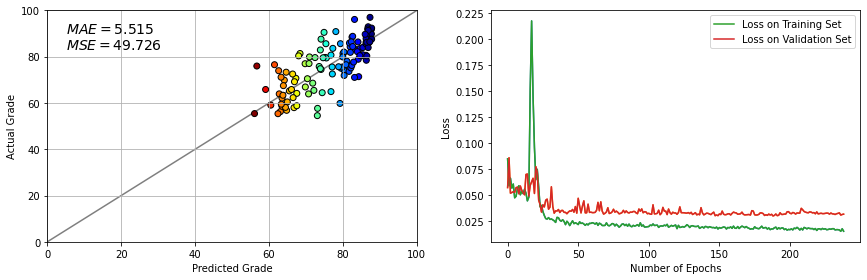

In [11]:
def main():
    input_Features, final_Grade, studentdf, student_list_unique = import_data()
    x_train_norm, x_test_norm, y_train_norm, y_test_norm, x_train_student, x_test_student, sc = process_data(input_Features, final_Grade)
    hype_var_list, optimize_gate = hyperparameter_optimization(hyp_opt = input("Optimize Hyperparameters? Y/N: "))
    EvaluateModel(hype_var_list, optimize_gate, x_train_norm, y_train_norm, x_test_norm, x_test_student, sc, student_list_unique, final_Grade)
#     predicted_Grade, loss_df = NeuralNetwork(x_train_norm, y_train_norm, x_test_norm, x_test_student, sc)
    
main()